# Algoritmus SIMPLE pro Navierovy-Stokesovy rovnice

## Navierovy-Stokesovy rovnice

Řešíme stacionární laminární proudění nestlačitelné tekutiny s konstantní hustotou popsané systémem Navierových-Stokesových rovnic
\begin{eqnarray*}
  \nabla\cdot\left(\vec{u}\otimes\vec{u}\right) - \nabla\cdot(\nu\nabla \vec{u}) &=& - \nabla p, \\
  \nabla\cdot\vec{u} &=& 0,
\end{eqnarray*}

$\vec{u}$ je rychlost, $p$ je podíl tlaku a hustoty (někdy nazývaný *kinematický tlak*) a $\nu$ je (konstantní) kinematická vazkost.

### Aproximace rovnice kontinuity

$$
\iint_{\Omega_c} \nabla\cdot\vec{u}\,dV
= \sum_{f} \int_{\Gamma_f} \vec{u}\cdot\vec{n}\,dS
\approx
\sum_{f} \vec{u}_f \cdot \vec{S}_f.
$$

$f$ probíhá přes všechny stěny buňky $\Omega_c$, $\vec{u}_f$ je aproximace $\vec{u}$ v těžišti stěny $f$. Označíme
$$
\phi_f := \vec{u}_f\cdot\vec{S}_f.
$$

potom aproximace rovnice kontinuity v buňce $c$ je
$$
\nabla\cdot\vec{u} \approx \frac{1}{|\Omega_c|}\sum_f \phi_f.
$$


### Aproximace vazkých členů

$$
\iint_{\Omega_c} \nabla\cdot(\nu \nabla\vec{u})\,dV
= \sum_{f} \int_{\Gamma_f} \nu (\nabla \vec{u})\cdot\vec{n}\,dS
\approx
\sum_{f} \nu \frac{\partial\vec{u}_f}{\partial n} \cdot \vec{S}_f.
$$

Na kartézské síti s krokem $h=\Delta x = \Delta y$ označme sousedy buňky $C$ indexy $N$ - soused nahoře, $W$ - soused vlevo, $S$ - soused dole a $E$ soused vpravo. Potom je (pro kartézskou síť) ve vnitřních buňkách sítě
$$
  \nabla\cdot(\nu \nabla\vec{u}) \approx \nu \frac{\vec{u}_N + \vec{u}_W + \vec{u}_S + \vec{u}_E - 4\vec{u}_C}{h^2}.
$$

Diskrétní verzi operátoru $\nu\nabla\cdot\cdot$ je tedy možné reprezentovat (na kartézské síti a při správném očíslování neznámých) pětidiagonální neostře diagonálně dominantní maticí. Při vhodně implementovaných okrajových odmínkách je tato matice symetrická.

### Aproximace konvektivních členů

Konvektivní člen je nelineární a proto je třeba provést linearizaci. Označme horním indexem $n$ novéhodnoty a horním indexem $o$ stávající známe hodnoty rychlosti. Linearizaci lze provést různým způsobem, pro algoritmus SIMPLE se používá tzv. Picardova aproximace

$$
\nabla\cdot(\vec{u}^n \otimes \vec{u}^n) \approx \nabla\cdot(\vec{u}^o \otimes \vec{u}^n)
$$

Potom aproximace tohoto členu pomocí MKO je 

$$
\iint_{\Omega_c} \nabla\cdot(\vec{u}^o\otimes\vec{u}^n)\,dV
= \sum_{f} \int_{\Gamma_f} \vec{n}\cdot\vec{u}^o\otimes\vec{u}^n\,dS
\approx
\sum_{f} \phi^o_f \vec{u}^n_f.
$$

Tedy
$$
\nabla\cdot(\vec{u}^o\otimes\vec{u}^n) \approx \frac{1}{|\Omega_f|}\sum_{f} \phi^o_f \vec{u}^n_f.
$$

Použijeme-li schéma **upwind** (např. pro tok mezi buňkami $C$ a $N$)
$$
   \phi_f \vec{u}_f = (\phi_f)^+ \vec{u}_C + (\phi_f)^- \vec{u}_N, 
$$
dostáváme

$$
\nabla\cdot(\vec{u}^o\otimes\vec{u}^n) \approx \frac{1}{|\Omega_f|}\left(
\sum_{f} (\phi^o_f)^+ \vec{u}^n_C + \sum_{f} (\phi^o_f)^- \vec{u}^n_F\right),
$$
kde $\vec{u}^n_F$ je hodnota řešení v buňce sousedící s $C$ stěnou $f$.

Diskrétní verze konvektivního členu je tedy reprezentovaná maticí s diagonálním prvkem
$$
\sum_{f} (\phi^o_f)^+.
$$
Mimo diagonálu jsou na odpovídajících místech (sloupce $N$, $E$, $S$ a $W$) příslušné hodnoty $(\phi_f)^-$.

Pokud je splněna rovnice kontinuity, tak je výsledná matice (při správně implementovaných okrajových podmínkách) **nesymetrická** a neostře diagonálně dominantní.

## Algoritmus SIMPLE

Algoritmus existuje v několika variantách (např. řešení rovnice pro tlak nebo pouze pro korekci tlaku, detaily diskretizace, ...). Na tomto místě popíšeme variantu používanou v sofwarovém balíku OpenFOAM.

Algoritmus je iterační a používá jako hlavní proměnné $\vec{u}$ a $p$ definované ve středech buňek a jako pomocnou proměnnou $\phi$ definovanou na stěnách. 

Na začátku výpočtu se určí $\phi$ na stěně $f$ jako $\phi_f = \vec{u}_f\cdot\vec{S}_f$ kde $\vec{u}_f = (\vec{u}_C + \vec{u}_F)/2$ je lineární interpolací rychlosti do středu stěny. V dalších krocích se $\phi$ počítá jinak.

Nejprve diskretizujeme rovnici pro rychlost (gradient tlaku zatím ponecháme formálně zapsany jako $\nabla p$):
$$
a_C^o \vec{u}_C^* = \sum_{f} a_F^o \vec{u}^*_F + Q_C - \nabla p_C^o = H(\vec{u}^*)_C - \nabla p_C^o.
$$
Protože byl použit *starý* tlak $p^o$, nedostaneme řešením této rovnice $\vec{u}^n$, ale pouze odhad $\vec{u}^*$. Ten však nemusí splňovat rovnici kontinuity. Vyjádříme proto
$$
\vec{u}_C^* =\frac{1}{a_C^o} H(\vec{u}^*)_C - \frac{1}{a_C^o}\nabla p_C^o = \hat{u}_C^* - \frac{1}{a_C^o}\nabla p_C^o.
$$
kde $\hat{u}_C^* := \frac{1}{a_C^o} H(\vec{u}^*)_C$.

Tento odhad rychlost interpolujeme na stěnu $f$
$$
\vec{u}_f^* = \hat{u}_f^* - \frac{1}{a_f^o}\nabla p_f^o.
$$


Pro $\vec{u}^n$ pak požadujeme splnění rovnice (pozor na horní indexy $n$, $o$ a $*$)>
$$
\vec{u}_f^n = \hat{u}_f^* - \frac{1}{a_f^o}\nabla p_f^n.
$$

Tato rychlost by však měla splňovat rovnici kontinuity, takže
$$
    0 = \sum_f \phi_f^n = \sum_f \vec{u}_f^n \cdot \vec{S}_f = \sum_f \hat{u}_f^* \cdot \vec{S}_f -
    \sum_f \frac{1}{a_f^o}\nabla p_f^n \cdot \vec{S}_f.
$$

Diskretizovaná rovnice pro tlak má tedy tvar
$$
\sum_f \frac{1}{a_f^o}\nabla p_f^n \cdot \vec{S}_f = \sum_f \hat{u}_f^* \cdot \vec{S}_f,
$$
což je diskrétní verze rovnice $\nabla\cdot(\frac{1}{a}\nabla p) = \nabla\cdot \hat{u}^*$.
Z nové hodnoty tlaku $p^n$ určíme novou hodnotu rychlosti a objemového toku $\phi$
\begin{eqnarray}
  \vec{u}^n_C &=& \hat{u}_C^* - \frac{1}{a_C^o}\nabla p_C^n, \\
  \phi_f^n &=& \hat{u}_f^*\cdot \vec{S}_f - \frac{1}{a_f^o}\nabla p_f^n\cdot\vec{S}_f.
\end{eqnarray}


**Jedna iterace algoritmu SIMPLE**
jedna iterace algoritmu SIMPLE zahrnující relaxaci v rovnice pro rychlost a explicitní relaxaci tlaku tedy vypadá následovně:
 
 1) ze známých hodnot $\vec{u}^o$ a $\phi^o$ sestavíme aproximaci levé strany rovnice pro rychlost (tj. bez vlivu gradientu tlaku)
 $$
   \nabla\cdot\left(\vec{u}^o\otimes\vec{u}^*\right) - \nabla\cdot(\nu\nabla \vec{u}^*) \approx
   a^o_C \vec{u}_C - H(\vec{u}^*)_C,
 $$
 
 2) provedeme relaxaci s koeficientem $\alpha$
 
 3) sestavíme a vyřešíme rovnici pro odhad rychlosti $\vec{u}^*$ se gradientem tlaku počítaným z $p^o$
 $$
   a^o_C \vec{u}^*_C = H(\vec{u}^*)_C - \nabla p^o_C,
 $$
 
 4) pomocí lineární interpolace určíme $\hat{u}_f$ ($F$ je index sousední buňky)
 $$
    \hat{u}_f^* = \text{interpolate}\left(\frac{1}{a^o_C}H(\vec{u}^*)_C, \frac{1}{a^o_F}H(\vec{u}^*)_F\right).
 $$
 
 5) sestavíme a vyřešíme rovnici pro tlak $p^*$
 $$
   \sum_f \frac{1}{a_f^o}\nabla p_f^* \cdot \vec{S}_f = \sum_f \hat{u}_f^* \cdot \vec{S}_f,
 $$
 
 6) nový tlak určíme z $p^o$ a $p^*$ pomocí relaxace s koeficientem $\beta$
 $$
   p^n = p^o + \beta(p^* - p^o)
 $$
 
 7) určíme nové hodnoty rychlosti a objemového toku
 \begin{eqnarray}
  \vec{u}^n_C &=& \hat{u}_C^* - \frac{1}{a_C^o}\nabla p_C^n, \\
  \phi_f^n &=& \hat{u}_f^*\cdot \vec{S}_f - \frac{1}{a_f^o}\nabla p_f^n\cdot\vec{S}_f.
 \end{eqnarray}

Výše uvedený postup opakujeme dokud proces nezkonverguje ke stacionárnímu stavu.

In [1]:
using PyPlot;

In [2]:
include("mesh.jl");
include("fields.jl");
include("operators.jl");

Vazké členy jsme již implementovali v minulé přednášce. Zbývá pouze konvektivní člen. Ten zapíšeme jako *div(phi, U)*

In [3]:
function div(ϕ::ScalarList , U::Field{T}) where {T}
    @assert length(ϕ) == length(U.mesh.owner)
    
    A = spzeros(length(U.values),length(U.values))
    b = zeros(T, length(U.values))
    
    mesh = U.mesh
    
    for f in internal_faces(mesh)
        o = mesh.owner[f]
        n = mesh.neighbor[f]
    
        α = max(ϕ[f], 0.0)
        β = min(ϕ[f], 0.0)
        
        A[o,o] += α / mesh.volume[o]
        A[o,n] += β / mesh.volume[o]
            
        A[n,o] -= α / mesh.volume[n]
        A[n,n] -= β / mesh.volume[n]
    end

    for p in boundary_patches(mesh)
        name = mesh.patch[p].name
        bc = U.boundaries[name]
        for f in patch_faces(mesh, p)
            o = mesh.owner[f]
            c1, c2 = boundary_coeffs(bc, f) 
            α = max(ϕ[f], 0.0)
            β = min(ϕ[f], 0.0)

            A[o,o] += (α + β*c2) / mesh.volume[o]
            b[o]   += β*c1 / mesh.volume[o]
        end
    end

    
    return Equation{T}(A, U.values, b)
end     

div (generic function with 2 methods)

Při spuštění výpočtu musíme vypočítat $\phi_f$ pomocí lineární interpolace

In [4]:
function create_ϕ_by_interpolation(U::VectorField)
    mesh = U.mesh
    ϕ = zeros(Scalar, length(all_faces(mesh)))
    
    for f in internal_faces(mesh)
        o = mesh.owner[f]
        n = mesh.neighbor[f]
        ϕ[f] = dot(mesh.surface[f], (U[o] + U[n]) / 2)
    end

    for p in boundary_patches(mesh)
        name = mesh.patch[p].name
        bc = U.boundaries[name]
        for f in patch_faces(mesh, p)
            o = mesh.owner[f]
            Uf = boundary_value(bc, f)
            ϕ[f] = dot(mesh.surface[f], Uf)
        end
    end

    return ϕ
end

create_ϕ_by_interpolation (generic function with 1 method)

V průběhu výpočtu budeme $\phi_f$ počítat z $\hat{u}$, $p$ a $1/a_f$. Máme
$$
\phi^n_f = \hat{u}_f\cdot\vec{S}_f - \frac{1}{a_f} \nabla p_f\cdot\vec{S}_f = 
\hat{u}_f\cdot\vec{S}_f - \frac{1}{a_f} \frac{\partial p}{\partial n} ||\vec{S}_f||.
$$

In [5]:
function calculate_ϕ!(ϕ::ScalarList, Ubar::VectorField, p::ScalarField, ra::ScalarList)
    mesh = Ubar.mesh
    for f in internal_faces(mesh)
        o = mesh.owner[f]
        n = mesh.neighbor[f]
        S = mesh.surface[f]
        δ = norm(mesh.centre[n] - mesh.centre[o])
        pn = (p[n] - p[o]) / δ
        ϕ[f] = dot(S, (Ubar[o]+Ubar[n])/2.) - (ra[o]+ra[n])/2 * pn * norm(S)
    end

    for pa in boundary_patches(mesh)
        name = mesh.patch[pa].name
        bc  = Ubar.boundaries[name]
        pbc = p.boundaries[name]
        for f in patch_faces(mesh, pa)
            o = mesh.owner[f]
            S = mesh.surface[f]
            Ub = boundary_value(bc, f)
            pb = boundary_value(pbc, f)
            pn = (pb - p[o]) / norm(mesh.centre[o] - mesh.facecentre[f])
            ϕ[f] = dot(S, Ub) - ra[o] * pn
        end
    end

end

calculate_ϕ! (generic function with 1 method)

In [6]:
function SIMPLE(U, p, ν; fix_pressure=true, iters=50)
    mesh = U.mesh
    α = 0.7
    β = 0.3

    ϕ = create_ϕ_by_interpolation(U)

    for iter = 0:iters
    
        UOld, pOld = copy(U.values), copy(p.values)
    
        
        UEqn = div(ϕ,U) - Δ(ν,U)

        relax!(UEqn, α)
    
        solve!(UEqn + grad(p))
    
        ra = 1 ./ Ac(UEqn);

        Ubar = VectorField(ra .* H(UEqn), U.mesh, U.boundaries);
    
        pEqn = Δ(ra, p) - div(Ubar);
        if fix_pressure
            pEqn.A[1,1] -= length(mesh.centre)
        end
        solve!(pEqn)
    
        p ← β*p + (1-β)*pOld
        U ← Ubar - ra .* grad(p)
    
        calculate_ϕ!(ϕ, Ubar, p, ra)
        
        if rem(iter,5)==0
            nxny = length(mesh.centre)
            pRez = norm(pOld - p.values) / nxny
            URez = norm(UOld - U.values) / nxny
            println(iter, "\t", pRez, "\t", URez)
        end

    end
    
    return U,p
end

SIMPLE (generic function with 1 method)

# Proudění v kavitě

Popis problému viz minulá přednáška, tentokrát však použijeme úplný systém Navierových-Stokesových rovnic.

In [7]:
function create_fields(mesh)
    U = VectorField(mesh)
    set_dirichlet_patch!(U, "left", Vector(0,0));
    set_dirichlet_patch!(U, "right", Vector(0,0));
    set_dirichlet_patch!(U, "bottom", Vector(0,0));
    set_dirichlet_patch!(U, "top", Vector(1,0));

    p = ScalarField(mesh);
    for name ∈ ["left", "right", "bottom", "top"]
        set_neumann_patch!(p, name)
    end

    return (U,p)
end;

In [8]:
function cavity_ns(ν, mesh)

    U,p = create_fields(mesh);
    U,p = SIMPLE(U, p, ν)
    return U,p
end

cavity_ns (generic function with 1 method)

In [9]:
ν = 0.01;
msh25 = cartesian_mesh(25,25);
U,p = cavity_ns(ν, msh25);

0	0.003954386650172468	0.0031633014957489266
5	0.0009313427996707457	0.0005820193295719031
10	0.00013548980578325113	0.0002550687683337284
15	0.0001784724800356979	0.0001512909706998142
20	0.00010612779116952935	0.00010613746710153284
25	4.4537132244249755e-5	7.866576767180226e-5
30	1.75533940318586e-5	5.997548804401451e-5
35	9.895685271588228e-6	4.658787470759539e-5
40	7.548678374529343e-6	3.6635281451369085e-5
45	6.3536038398134935e-6	2.9026630573720348e-5
50	5.382903568879144e-6	2.3096888945097373e-5


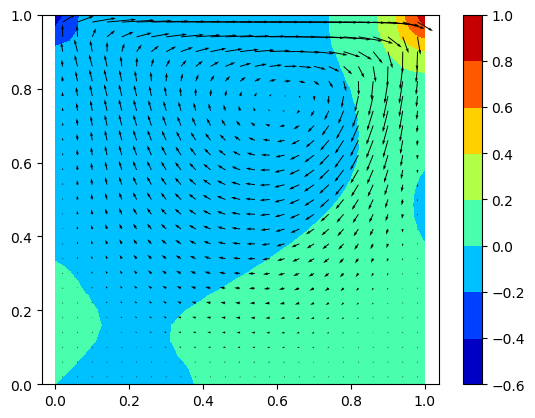

In [10]:
plot_contourf(p; cmap="jet"); colorbar();
plot_arrows(U);
axis("equal");

## Jemnější síť a menší viskozita

In [11]:
ν = 1.e-3;
msh50 = cartesian_mesh(50,50);

In [12]:
U,p = cavity_ns(ν, msh50);

0	0.00039379457172874843	0.0011611564177153332
5	0.00013366440194912557	0.00018143208796904555
10	2.2293425535824932e-5	0.00010599819220560736
15	1.9249245570140867e-5	8.185950976471178e-5
20	1.706657689144141e-5	7.0895984204923e-5
25	1.2710589849254498e-5	6.46642927263591e-5
30	1.0287541290049851e-5	6.041337521272537e-5
35	9.037281288737825e-6	5.663356601918018e-5
40	8.260620382093266e-6	5.3002191145150027e-5
45	7.656750089874052e-6	4.9475187988549e-5
50	7.1131387194121545e-6	4.6047261110254215e-5


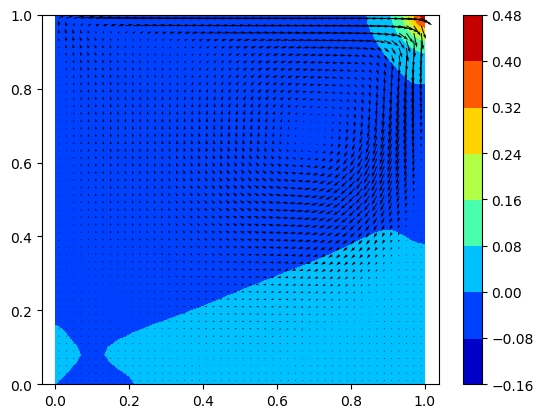

In [13]:
plot_contourf(p; cmap="jet"); colorbar();
plot_arrows(U);
axis("equal");

In [14]:
component(f::VectorField, c) = [ v[c] for v in f.values ]

n=50
uu = reshape(component(U,1), (n,n));
vv = reshape(component(U,2), (n,n));
pp = reshape(p.values, (n,n));

In [15]:
# Ψ_x = v, Ψ_y = - u

function streamfunction(u, v, Δx=1, Δy=1)
    Ψ1 = zero(u)

    Ψ1[1,1] = 0.0
    for i=2:size(u,1)
        Ψ1[i,1] = Ψ1[i-1,1] + Δx * (v[i,1]+v[i-1,1])/2
    end
    for j=2:size(u,2)
        Ψ1[:,j] = Ψ1[:,j-1] - Δy * (u[:,j]+u[:,j-1])/2
    end

    Ψ2 = zero(Ψ1)
    
    Ψ2[1,1] = 0.0
    for j=2:size(u,2)
        Ψ2[1,j] = Ψ2[1,j-1] - Δy * (u[1,j,1]+u[1,j-1])/2
    end
    for i=2:size(u,1)
        Ψ2[i,:] = Ψ2[i-1,:] + Δx * (v[i,:]+v[i-1,:])/2
    end
    
    Ψ = (Ψ1 + Ψ2) / 2
    
    #Ψ[end,end] = (Ψ[end-1,end]+Ψ[end,end-1]) / 2
    return Ψ
end

streamfunction (generic function with 3 methods)

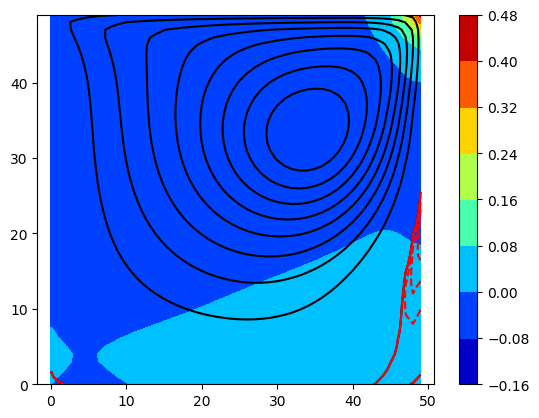

In [16]:
Ψ = streamfunction(uu,vv,1/50,1/50);

pos = range(0, maximum(Ψ), length=10)
contour(Ψ', pos, colors="black");
neg = range(minimum(Ψ), 0, length=5)
contourf(pp'; cmap="jet"); colorbar();
contour(Ψ', neg, colors="red");
axis("equal");

## Vypočet na nestrukturované síti

Řešíme problém ustáleného obtékání eliptického tělesa v kanále nevazkou nestlačitelnou tekutinou popsanou systémem Navierových-Stokesových rovnic. Při řešení uvažujeme následující okrajové podmínky:
 - levá hranice (vstup): $u=(1,0)$ a $\partial p / \partial n = 0$
 - pravá hranice (výstup): $\partial u/\partial n = 0$ a $p = 0$
 - horní a dolní hranice: $u=(0,0)$ a $\partial p / \partial n = 0$
 - obtékané těleso: $u=(0,0)$ a $\partial p / \partial n = 0$
 
obrázek oblasti viz níže

In [17]:
include("gmsh_mesh.jl")

gmsh_mesh (generic function with 1 method)

In [18]:
gmsh = gmsh_mesh("domain.msh");

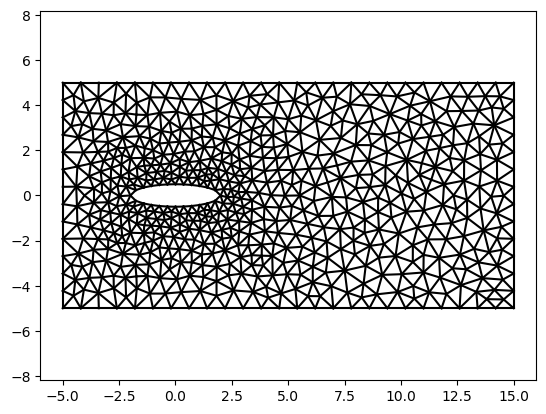

In [19]:
plot_mesh(gmsh)
axis("equal");

In [20]:
patch_names(gmsh)

5-element Array{String,1}:
 "TOP"    
 "OUTLET" 
 "BOTTOM" 
 "PROFILE"
 "INLET"  

In [21]:
U = VectorField(gmsh)
set_dirichlet_patch!(U, "INLET", Vector(1,0));
set_dirichlet_patch!(U, "TOP", Vector(0,0));
set_dirichlet_patch!(U, "BOTTOM", Vector(0,0));
set_dirichlet_patch!(U, "PROFILE", Vector(0,0));
set_neumann_patch!(U, "OUTLET");
U.values[:] = [Vector(1,0) for c in cells(gmsh)]

p = ScalarField(gmsh);
for name ∈ ["INLET", "PROFILE", "TOP", "BOTTOM"]
    set_neumann_patch!(p, name)
end
set_dirichlet_patch!(p, "OUTLET", 0.0);

In [22]:
U,p = SIMPLE(U, p, 1.e-3, fix_pressure=false, iters=100);

0	0.01320064755067597	0.0023074718509579536
5	0.00802833169108605	0.0005953211697410505
10	0.0035927633033289164	0.00037123646477498336
15	0.0009435004753181014	0.0001496983687921182
20	0.0002838994518982319	6.170762805817095e-5
25	0.00026411717328420694	2.467994095292978e-5
30	5.8001984240376655e-5	1.3214375203446303e-5
35	1.2634339558913047e-5	6.464143263012179e-6
40	8.27905538091566e-6	2.873321673740732e-6
45	3.758162123910306e-6	1.5465536656263301e-6
50	1.780497887249392e-6	8.863326173833504e-7
55	1.1107180544857576e-6	5.977561343311247e-7
60	9.044482283054537e-7	3.7969259033145676e-7
65	6.647126903481037e-7	2.5007725441437235e-7
70	2.933342738325574e-7	1.765284685991397e-7
75	1.2317469293832773e-7	1.2985302179181044e-7
80	1.1658603528929908e-7	9.29175507602859e-8
85	6.603097281104495e-8	6.83581838447192e-8
90	4.145791337885607e-8	5.069535038809639e-8
95	3.0719380714308483e-8	3.769858268139703e-8
100	2.271213560577168e-8	2.8122455393788428e-8


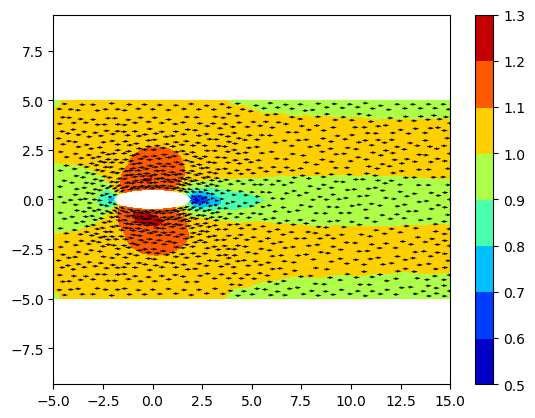

In [23]:
plot_contourf(U; cmap="jet"); colorbar();
plot_arrows(U);
axis("equal");

## Výpočet na síti se zjemněním u stěny

In [24]:
gmf = gmsh_mesh("domain_bl.msh");

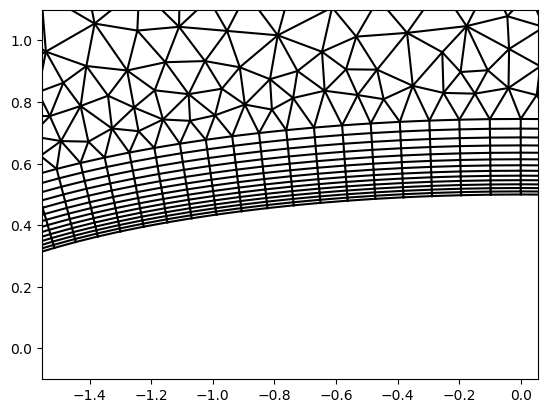

In [25]:
plot_mesh(gmf);
axis("equal");
xlim(-1.5,0); ylim(-0.1,1.1);

In [26]:
length(cells(gmf))

3988

In [27]:
patch_names(gmf)

5-element Array{String,1}:
 "TOP"    
 "OUTLET" 
 "BOTTOM" 
 "PROFILE"
 "INLET"  

In [28]:
Uf = VectorField(gmf)
set_dirichlet_patch!(Uf, "INLET", Vector(1,0));
set_dirichlet_patch!(Uf, "TOP", Vector(0,0));
set_dirichlet_patch!(Uf, "BOTTOM", Vector(0,0));
set_dirichlet_patch!(Uf, "PROFILE", Vector(0,0));
set_neumann_patch!(Uf, "OUTLET");
Uf ← [Vector(1,0) for c in cells(gmf)]

pf = ScalarField(gmf);
for name ∈ ["INLET", "PROFILE", "TOP", "BOTTOM"]
    set_neumann_patch!(pf, name)
end
set_dirichlet_patch!(pf, "OUTLET", 0.0);

In [29]:
Uf,pf = SIMPLE(Uf, pf, 1.e-2, fix_pressure=false, iters=10);

0	0.038589726480548446	0.0017800536137290459
5	0.01935677792910062	0.0006796930119209985
10	0.005675544667418478	0.0005761775772204923


In [30]:
Uf,pf = SIMPLE(Uf, pf, 1.e-3, fix_pressure=false, iters=50);

0	0.002743989579133127	0.0007287874017782403
5	0.0011430280876983151	0.0004799918024760951
10	0.000460386824278761	0.0002610821293494769
15	0.0001252732545679363	0.00014093897905312735
20	9.443214275967843e-5	8.961099486556777e-5
25	4.507412044495838e-5	6.0568955122828145e-5
30	1.9753486398563542e-5	3.973068466177771e-5
35	6.956636339999515e-6	2.466381532749566e-5
40	6.4011833108226405e-6	1.52768978936901e-5
45	3.674592491566292e-6	9.664242565035096e-6
50	2.0950872679181326e-6	6.71575877856642e-6


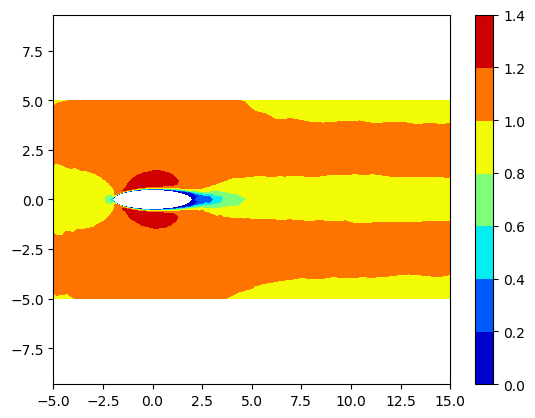

In [31]:
plot_contourf(Uf; cmap="jet"); colorbar();
#plot_arrows(Uf);
axis("equal");

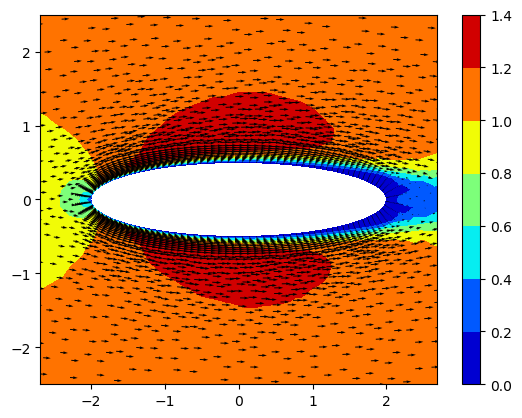

In [32]:
plot_contourf(Uf; cmap="jet"); colorbar();
plot_arrows(Uf; units="xy", scale=10);
axis("equal");
xlim(-1.5,1.5); ylim(-2.5,2.5);